We need a light level of 9. The probability of a crop growing upon recieving a random tick is $\frac{1}{\lfloor 25/points \rfloor + 1}$ where points is the following.

- The farmland block the crop is planted on gives 2 points if dry or 4 if hydrated.
- For each of the 8 blocks around the block on which the crop is planted, dry farmland gives 0.25 points, and hydrated farmland gives 0.75.
- If any plants of the same type are growing in the eight surrounding blocks, the point total is cut in half (except in some cases. See https://minecraft.fandom.com/wiki/Tutorials/Crop_farming#Growth_rate)

We will assume that all farmland is hydrated.

In [1]:
from sympy import *

# we calculate points for blocks that are surrounded by farmland (and crops on that farmland)
middle_points = (4 + Rational("0.75") * 8)/2

middle_probability = 1 / (floor(25/middle_points) + 1)
middle_probability

1/6

In [2]:
# we calculate points for blocks that are on the side
#   O X O
#   O O O
side_points = (4 + Rational("0.75") * 5)/2

side_probability = 1 / (floor(25/side_points) + 1)
side_probability

1/7

In [3]:
# we calculate points for blocks that are in the corner
#   X O
#   O O
corner_points = (4 + Rational("0.75") * 3)/2

corner_probability = 1 / (floor(25/corner_points) + 1)
corner_probability

1/9

In [4]:
# For now we ignore that there's water in the middle
width = 18
depth = 9

corner_blocks = 4
side_blocks = (width-2)*2 + (depth-2)*2
middle_blocks = (width-2) * (depth-2)
total_blocks = width*depth
assert(corner_blocks + side_blocks + middle_blocks == total_blocks)

Every game tick, each 16x16x16 subchunk receives a number of attempts at random ticks (by default $3$, given by the randomTickSpeed game rule). For now we'll just consider a single random tick. In a subchunk there are $4096$ blocks, so a $\frac{1}{4096}$ chance of a block being chosen for a random tick.

In [5]:
block_chance = Rational("1/4096")
chance_of_not_growing = 1-block_chance*middle_probability

# We assume we only have middle_blocks, and we want to know how many ticks it takes to have 50% of the crops be grown.
wanted_growth = Rational("0.8")
ticks_needed = ln(1-wanted_growth) / ln(chance_of_not_growing)
display(ticks_needed.n())
minutes_needed = (ticks_needed/20)/60
minutes_needed.n()

39552.7414115668

32.9606178429723

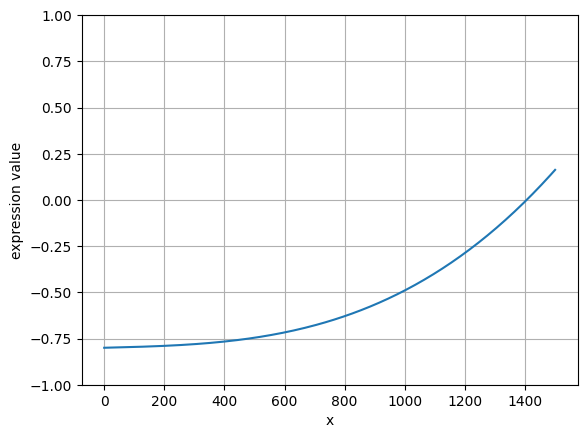

23.42254263087336

In [6]:
k, c = symbols("k c")

expr = k + k*c**k - 2*(c*(1-c**k)/(1-c))
# display(expr)
expr = expr.subs(c, chance_of_not_growing)
# solve(Eq(expr, wanted_growth))
# This doesn't work. Sympy can't solve it.
from scipy.optimize import fsolve
import numpy as np
import math
import matplotlib.pyplot as plt

# We create a function that scipy understands.
# The function is expr - wanted_growth, so that the roots are the solution to
# expr == wanted_growth
def np_pow(b, e):
    return np.exp(e*math.log(b))

c = float(chance_of_not_growing.n())
# func = lambda x: x + x*np_pow(c, x) - 2*(c*(1-np_pow(c, x))/(1-c)) - wanted_growth
def func(x):
    if len(x) == 1:
        x = x[0]
    res = x + x*np_pow(c, x) - 2*(c*(1-np_pow(c, x))/(1-c)) - wanted_growth
    # print(res)
    return res

x = np.linspace(0.0, 1500.0, 201)
plt.plot(x, func(x))
plt.xlabel("x")
plt.ylabel("expression value")
plt.grid()

ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([-1, 1])

plt.show()

x0 = float(fsolve(func, 1500.0))
ticks_needed = x0
seconds_needed = x0 / 60
seconds_needed

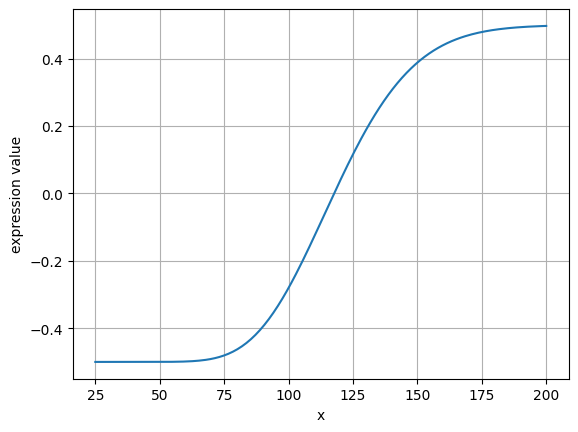

118

In [7]:
import scipy

pr_of_getting_six = 1/6
pr_of_not_getting_six = 5/6

wanted_chance = 0.5

# Probability of some event with probability p happening exactly k times in n attempts.
def bleh(p, k, n):
    return p**k * (1-p)**(n-k) * scipy.special.binom(n, k)

# Probability of some event with probability p happening at least k times in n attempts.
def foo(p, k, n):
    sum = 1
    for i in range(0, k):
        sum -= bleh(p, i, n)
    return sum

def func(x):
    if type(x) != float and len(x) == 1:
        x = x[0]
    # res = 1 - (np_pow(pr_of_not_getting_six, x) + scipy.special.binom(x, 1) * np_pow(pr_of_not_getting_six, x-1) * pr_of_getting_six) - wanted_chance
    # res = 1 - bleh(pr_of_getting_six, 0, x) - bleh(pr_of_getting_six, 1, x) - bleh(pr_of_getting_six, 2, x) - wanted_chance
    res = foo(pr_of_getting_six, 20, x) - wanted_chance
    return res

x = np.linspace(25.0, 200.0, 201)
plt.plot(x, func(x))
plt.xlabel("x")
plt.ylabel("expression value")
plt.grid()

# ax = plt.gca()
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([-1, 1])

plt.show()

x0 = float(fsolve(func, 100.0))
display(math.ceil(x0))


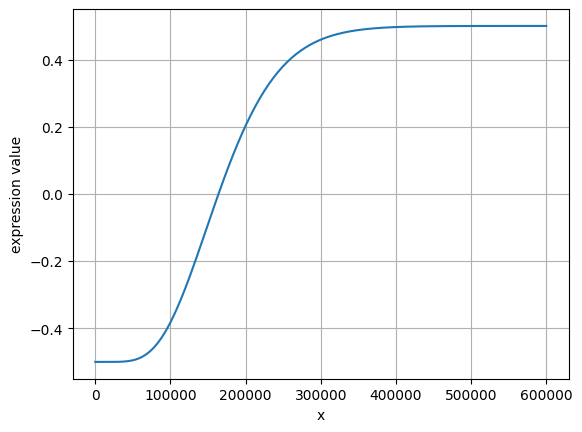

In order to have roughly 0.5 of the farm be done, we need to wait 2.276564804525512 hours


In [10]:
growth_events_needed = 7
wanted_growth = 0.5
chance_of_growing = block_chance*middle_probability

def func(x):
    if type(x) != float and len(x) == 1:
        x = x[0]
    res = foo(chance_of_growing, growth_events_needed, x) - wanted_growth
    return res

x = np.linspace(0.0, 600000.0, 201)
plt.plot(x, func(x))
plt.xlabel("x")
plt.ylabel("expression value")
plt.grid()

# ax = plt.gca()
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([-1, 1])

plt.show()

x0 = float(fsolve(func, 200000.0))
ticks_needed = x0
hours_needed = ticks_needed/20/60/60
print(f"In order to have roughly {wanted_growth} of the farm be done, we need to wait {hours_needed} hours")
